<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_flujo_alimentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: optimización de flujo de alimentación $F_{in}$

Autor: Juan Manuel Gutiérrez García

Afiliación: Instituto Tecnológico de Morelia

Fecha: enero 2021

# Resumen

En el siguiente cuaderno describimos  la optimización de un biorreactor tipo lote-alimentado. En el proceso nos interesa maximizar la cantidad de biomasa generada al final de la fermentación. Se considera un flujo variable en la alimentación y una restricción en el volumen del biorreactor. El problema consiste en  encontrar el perfil de alimentación óptimo que nos permita maximizar la producción de biomasa en la fermentación. El análisis de hace con los parámetros óptimos obtenidos con datos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zygosaccharomyces rouxi* 

# Modelo con restricción de volumen

Consideramos el caso en que el volumen del biorreactor tiene un límite, es decir, al momento de alimentar un flujo al biorreactor se debe considerar que este tiene una capacidad máxima y no es posible sobrepasar dicha capacidad. Por lo tanto, el flujo de alimentación al biorreactor se puede escribir como

$$\begin{equation*}
F_{in}(t) = \left\{
        \begin{array}{ll}
            F_{in} & \quad V \leq V_{lim} \\
            0 & \quad V > V_{lim}
        \end{array}
    \right.
\end{equation*}$$

# Establecer función objetivo

El problema de optimización aquí es maximizar la cantidad de biomasa al final de la fermentación. Por tanto, la función objetivo se puede formular de la siguiente manera:

$$max_{F_{in}(t)}\ J = x(t_f)V(t_f)$$
La optimización está sujeta a la restricción

$$ 0 < F_{in}(t) < 3\ L/h$$

Parámetros del algoritmo genético
Para el correcto funcionamiento del algoritmo genético usando la función ga() es necesario establecer un valor adecuado de los parámetros popSize, pcrossover, pmutation, elitism y maxiter. Además se deben establecer el valor mínimo y máximo para el parámetro a optimizar

Tabla 1. Valores de parámetros usados en la optimización

|parámetro|	valor|
|:---:|:---:|
|tamaño de población|	50|
|probabilidad de cruzamiento|	0.8|
|probabilidad de mutación|	0.1|
|elitismo|	2|
|número de generaciones (Fin constante)|	10|
|número de generaciones (Fin variable)|	100|

\\
Tabla 2. Valor mínimo y máximo de $F_{in}$

|parámetro|	mínimo|	máximo|
|:---:|:---:|:---:|
|$F{in} $ (L/h)|	0|	2|


Tabla 3. Parámetros de operación usados durante el análisis

|parámetro| valor|
|:---:|:---:|
$s_f$ | 50 g/L
$V_{lim}$ | 60 L
$t_f$ | 100 h
$x_0$ | 0.2 g/L
$s_0$ | 40 g/L
$p_0$ | 0 g/L
$V_0$ | 10 L

Tabla 4. Parámetros cinéticos de las cinco levaduras

|parámetro| IT | KM | PK | ZB | ZR | 	
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\mu_{max}$ (1/h)|2.410|2.308|2.291|2.021|1.465
|$k_s$ (g/L)|311.651|342.040|333.910|347.062|362.378
|$k_i$ (L/g)|0.190|0.269|0.230|0.272|0.601
|$Y_{xs}$|0.089|0.066|0.0850|0.0564|0.193
|$Y_{px}$|8.577|9.552|5.044|10.397|3.266
              

In [1]:
# instalar paquetes 
install.packages("deSolve")
install.packages("GA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’




In [2]:
# cargar librerías
library(deSolve)
library(ggplot2)
library(GA)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de




In [18]:
# @title establecer modelo con restricción
model <- function(times, state, parms) {
        with(as.list(c(state,parms)), {
                
                if (V > Vl) {

                        Fin = 0
                }
                
                # velocidad de crecimiento de biomasa
                rx = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rx

                # velocidad de generación de producto
                rp = Ypx*rx
                
                # balance de material global 
                dVdt = Fin 
                
                # balance de materia para sustrato
                dsdt = Fin/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fin/V*x + rx
                
                # balance de materia para el producto
                dpdt = - Fin/V*p + rp

                return(list(c(dVdt, dsdt, dxdt, dpdt), Fin = Fin))
        })
}

In [5]:
#@title función para variar Fin durante el proceso, considerando la restricción V < Vl
change_input <- function(times, state, parms, Fin, model) {
        
        n <- length(times)
        # vectores para guardar los resultados
        V0 <- state[1]
        V <- rep(V0, n)
        s0 <- state[2]
        su <- rep(s0,n)
        x0 <- state[3]
        x <- rep(x0,n)
        p0 <- state[4]
        p <- rep(p0,n)
        
        # resolver EDO para los diferentes valores de Fin
        
        for (i in 1:(n-1)) {
                
                # actualizar tiempo de integración
                tspan <- c(times[i], times[i+1])
                
                # actualizar Fin
                parms["Fin"] <- Fin[i+1]
                
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           method = "rk4")
                
                m <- nrow(out)
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                out <- as.data.frame(out)
                # guardar resultados 
                V[i+1] <- out$V[m]
                su[i+1] <- out$s[m]
                x[i+1] <- out$x[m]
                p[i+1] <- out$p[m]
                Fin[i+1] <- out$Fin[m]
        }
        
        return(list(times = times, V = V, s = su, x = x, p = p, Fin = Fin))
}

In [44]:
# perfil Fin para la simulación 
n <- length(times)
Fin <- rep(0, n)
Fin[21:n] <- 1

In [45]:
# establecer parámetros 
p <- c(mu_max = 1.2, ks = 280, Yxs = 0.2, Ypx = 4, sf = 50, Fin = 1, ki = 0.3, Vl = 60)

In [46]:
# condiciones iniciales
s <- c(V = 10.0, s = 40, x = 0.2, p = 0)

In [47]:
# tiempo de integración 
times <- seq(0,100,len=100)

In [48]:
# simular proceso con Fin variable 
out <- change_input(state = s, times = times, parms = p, Fin = Fin, model = model)
out <- as.data.frame(out)

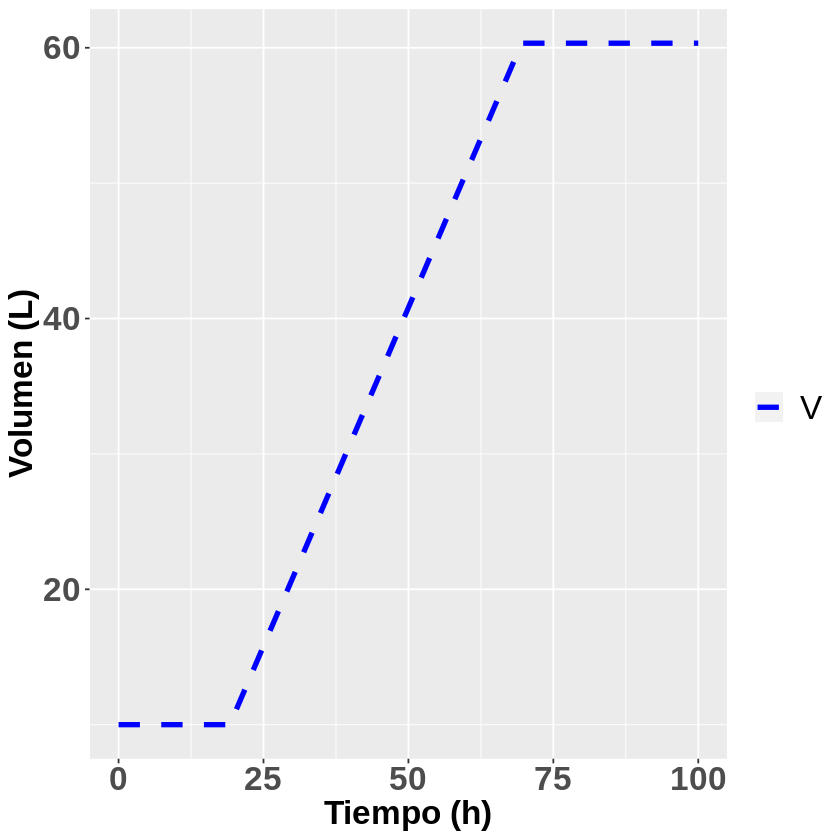

In [49]:
# mostrar resultados de volumen
ggplot(out, aes(times)) +
        geom_line(aes(y = V, color = "V"), lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Tiempo (h)") +
        ylab("Volumen (L)")   +
        theme(  
            title = element_text(size = 20),
            axis.text=element_text(size=20, face = "bold"),
            axis.title=element_text(size=20,face="bold"),
            legend.title = element_text(size=20), 
            legend.text = element_text(size=20))

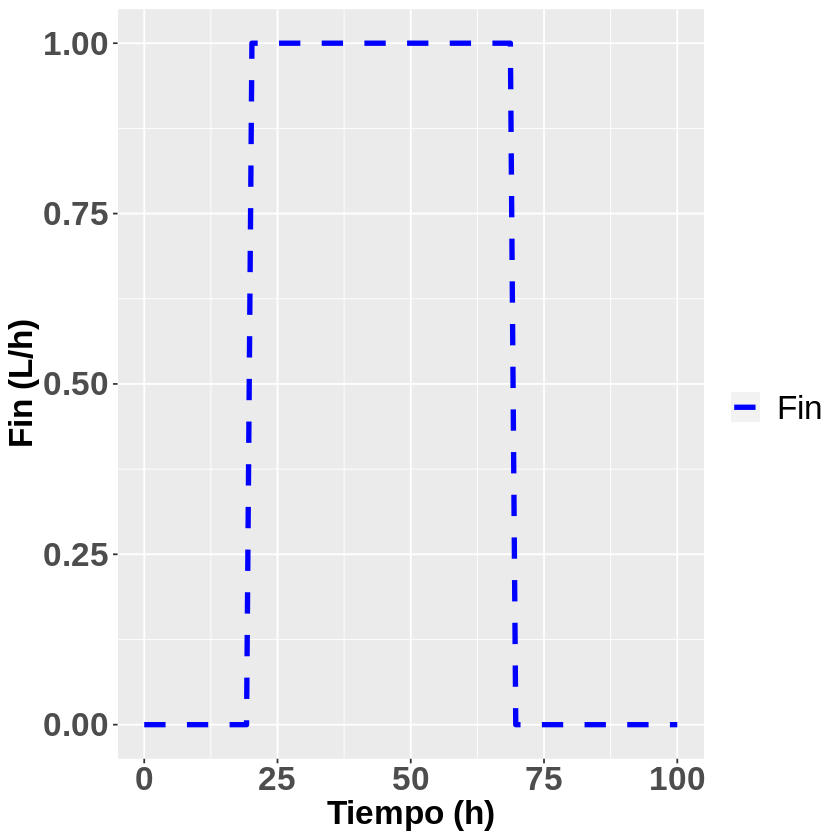

In [50]:
# mostrar resultados de Fin
ggplot(out, aes(times)) +
        geom_line(aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("Fin"), values = c("blue")) +
        xlab("Tiempo (h)") +
        ylab("Fin (L/h)")   +
        theme(  
            title = element_text(size = 20),
            axis.text=element_text(size=20, face = "bold"),
            axis.title=element_text(size=20,face="bold"),
            legend.title = element_text(size=20), 
            legend.text = element_text(size=20))

#Encontrar el perfil de alimentación $F_{in}$ que genera la máxima producción de biomasa, considerando que $V < V_{lim}$

Ahora optimizamos para encontrar el perfil $F_{in}$ que genere una máxima producción de biomasa

In [85]:
# @title función fitness para encontrar el perfil óptimo Fin de alimentación al biorreactor
fitness <- function(x, times, state, parms, model, change_input) {
        # x es el vector  con valores de Fin 
        # x tiene una longitud de 10, para hacerlo de tamaño 100 usamos rep()
        Fin <- rep(x, each = 10)
        # simular usando Fin variable 
        out <- change_input(times = times, state = s, parms = parms, Fin = Fin, model = model)
        n <- length(out$V)
        # biomasa generada con el perfil Fin
        mx_end <- out$x[n]*out$V[n]
        
        return(mx_end)
}

In [39]:
# realizar optimización 
set.seed(456)
time1 <- Sys.time()
GA1 <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [40]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.871339 mins

In [41]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA1@fitnessValue, "g")

mx_opt: 565.3705 g

In [42]:
# guardar perfil óptimo
Fin_opt1 <- rep(GA1@solution, each = 10)

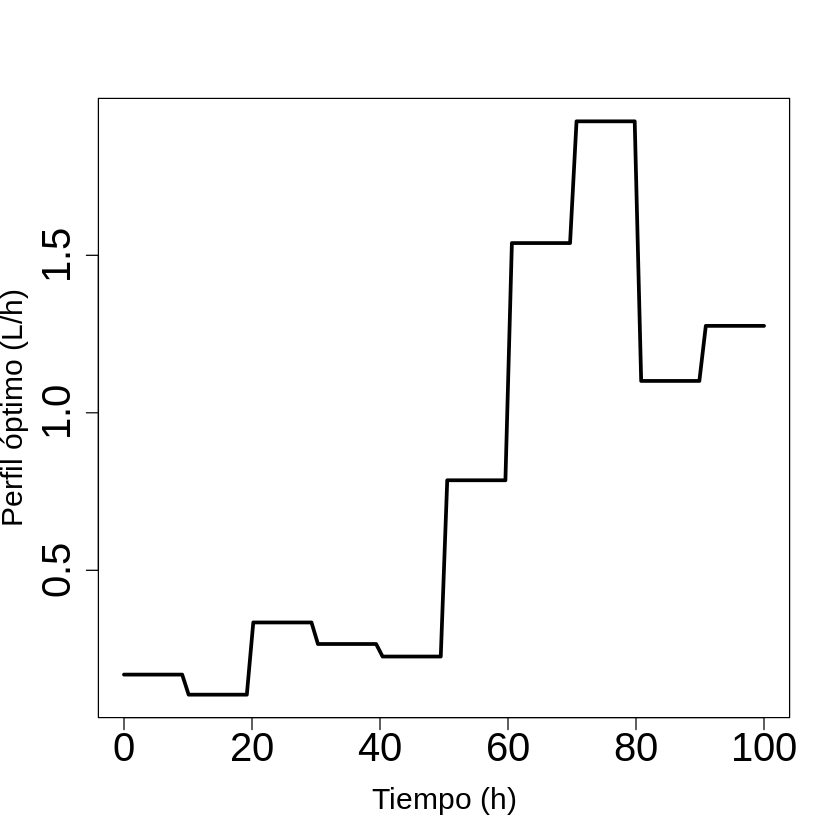

In [43]:
# graficar perfil óptimo
plot(times, Fin_opt1, type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)

# Optimización de Fin para *Isstchenkia terrícola*

In [67]:
p_it <- c(mu_max = 2.4102375, ks = 311.6519179, ki = 0.1908231, Yxs = 0.0897973, Ypx = 8.5770722,sf = 50, Fin = 1, Vl = 60)

In [86]:
# realizar optimización 
set.seed(123)
time1 <- Sys.time()
GA_it <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p_it,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [87]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.905489 mins

In [88]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_it@fitnessValue, "g")

mx_opt: 266.479 g

In [73]:
# guardar perfil óptimo
Fin_opt_it <- rep(GA_it@solution, each = 10)

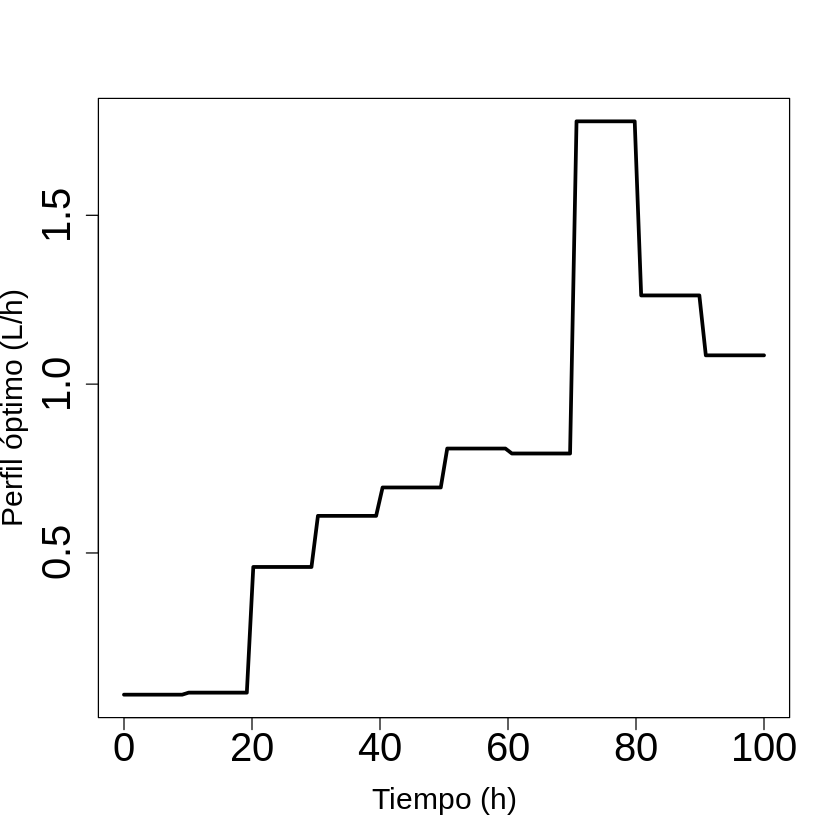

In [74]:
# graficar perfil óptimo
plot(times, Fin_opt_it, type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)

# Optimización de Fin para *Kluyveromyces marxianus*

In [89]:
p_km <- c(mu_max = 2.30834, ks = 342.0408, ki = 0.2696911, Yxs = 0.06644916, Ypx = 9.552475, sf = 50, Fin = 1, Vl = 60)

In [90]:
# realizar optimización 
set.seed(123)
time1 <- Sys.time()
GA_km <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p_km,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [91]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.920587 mins

In [121]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_km@fitnessValue, "g")

mx_opt: 197.7277 g

In [125]:
# guardar perfil óptimo
Fin_opt_km <- rep(GA_km@solution, each = 10)

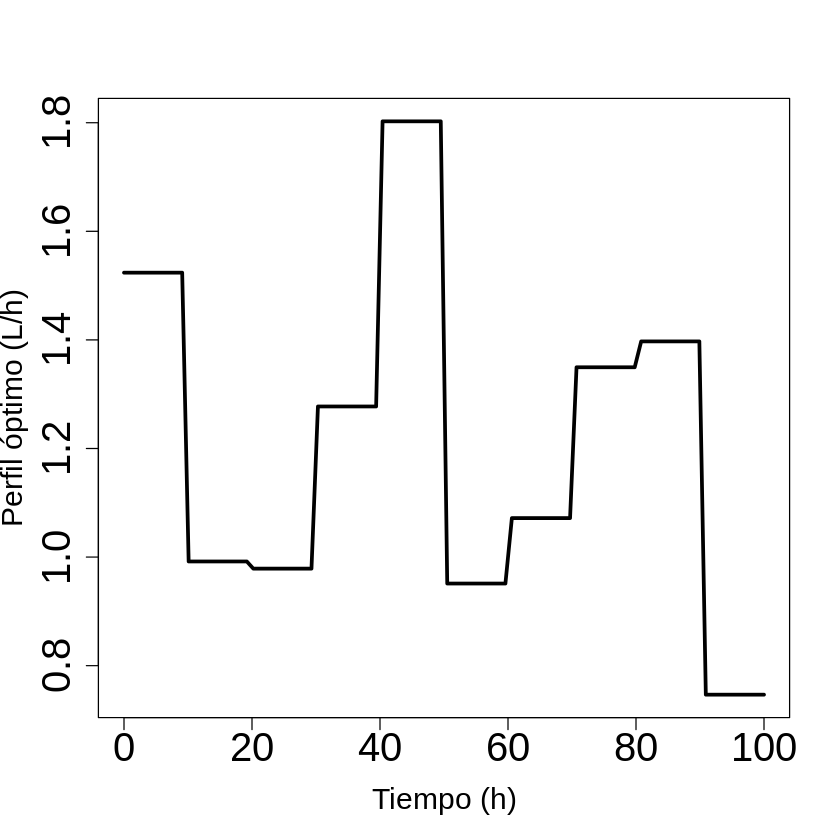

In [94]:
# graficar perfil óptimo
plot(times, Fin_opt_km, type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)

# Optimización de Fin para *Pichia kluyveri*

In [95]:
p_pk <- c(mu_max = 2.29138884, ks = 333.91000241, ki = 0.23049849, Yxs = 0.08504201, Ypx = 5.04443297 , sf = 50, Fin = 1, Vl = 60)
p_km <- c(mu_max = 2.30834, ks = 342.0408, ki = 0.2696911, Yxs = 0.06644916, Ypx = 9.552475, sf = 50, Fin = 1, Vl = 60)

In [96]:
# realizar optimización 
set.seed(123)
time1 <- Sys.time()
GA_pk <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p_pk,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [99]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.941079 mins

In [120]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_pk@fitnessValue, "g")

mx_opt: 252.4936 g

In [101]:
# guardar perfil óptimo
Fin_opt_pk <- rep(GA_pk@solution, each = 10)

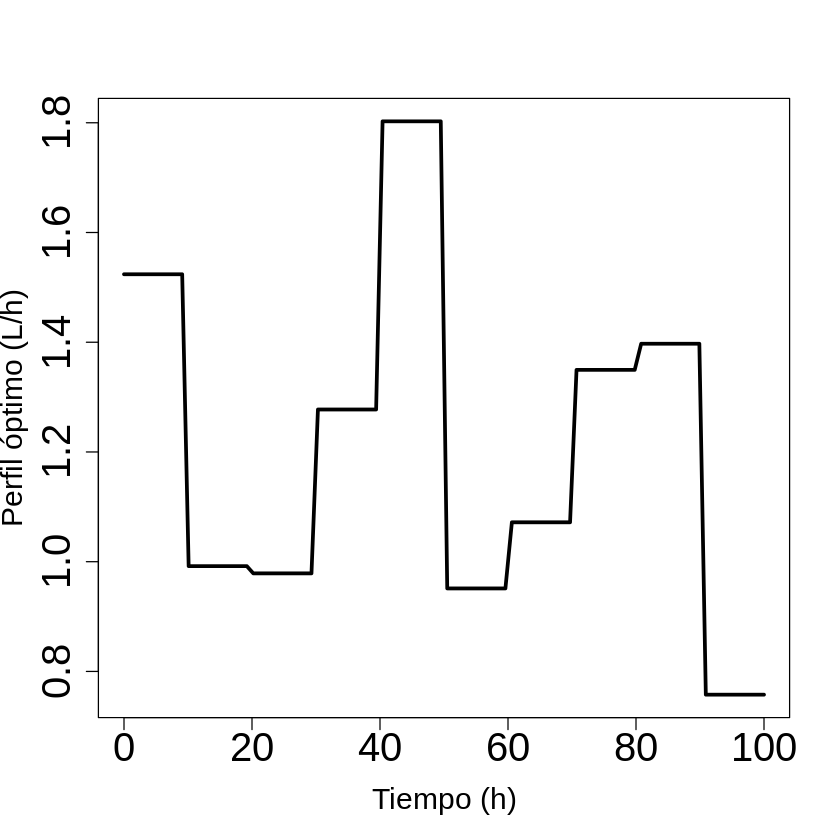

In [119]:
# graficar perfil óptimo
matplot(times, Fin_opt_pk,Fin_opt_km,, col = c(1,2), type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)

# Optimización de Fin para *Zygosaccharomyces bailii*

In [103]:
p_zb <- c(mu_max = 2.021993, ks = 347.0626, ki = 0.272369, Yxs = 0.05646044, Ypx =  10.39769 , sf = 50, Fin = 1, Vl = 60)

In [104]:
# realizar optimización 
set.seed(123)
time1 <- Sys.time()
GA_zb <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p_zb,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [105]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.938422 mins

In [106]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_zb@fitnessValue, "g")

mx_opt: 168.4537 g

In [107]:
# guardar perfil óptimo
Fin_opt_zb <- rep(GA_zb@solution, each = 10)

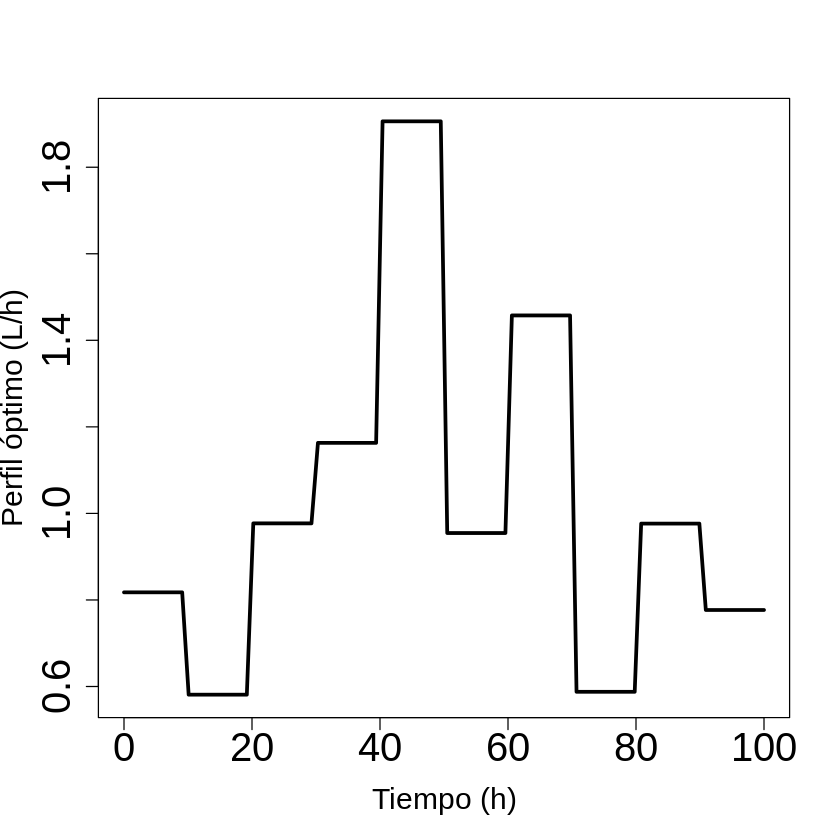

In [108]:
# graficar perfil óptimo
plot(times, Fin_opt_zb, type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)

# Optimización de Fin para *Zygosaccharomyces rouxi*

In [109]:
p_zr <- c(mu_max = 1.465104,ks = 362.3786, ki = 0.6013461, Yxs = 0.1931217, Ypx = 3.266812, sf = 50, Fin = 1, Vl = 60)

In [110]:
# realizar optimización 
set.seed(123)
time1 <- Sys.time()
GA_zr <- ga(type = "real-valued",
          fitness = fitness,
          times= times,
          state = s,
          parms = p_zr,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [111]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.914612 mins

In [112]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_zr@fitnessValue, "g")

mx_opt: 172.5102 g

In [113]:
# guardar perfil óptimo
Fin_opt_zr <- rep(GA_zr@solution, each = 10)

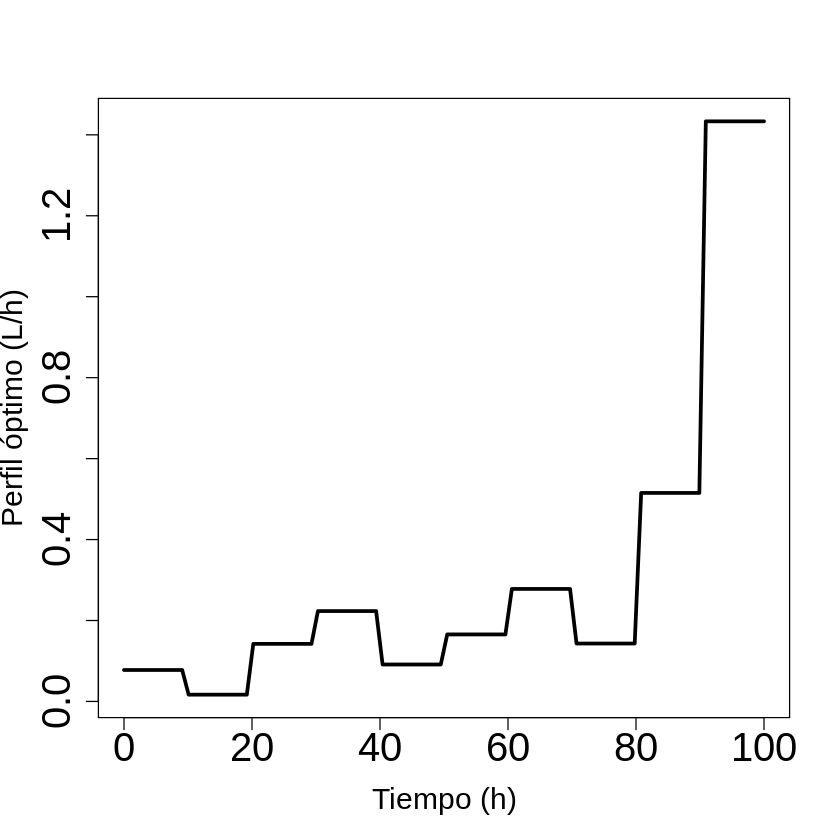

In [114]:
# graficar perfil óptimo
plot(times, Fin_opt_zr, type = "l", lwd = 3, 
    ylab = "Perfil óptimo (L/h)", xlab = "Tiempo (h)", cex.lab = 1.5, cex.axis = 2)